In [1]:

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import rioxarray

# Land Cover Dataset

In [16]:
#  Charger les shapefiles Land Cover 
landcover_alg = gpd.read_file("../data/geonetwork_landcover_DZA_gc_adg/dza_gc_adg.shp")
landcover_tun = gpd.read_file("../data/geonetwork_landcover_tun_gc_adg/tun_gc_adg.shp")

print("Land Cover Algeria CRS:", landcover_alg.crs)
print("Land Cover Tunisia CRS:", landcover_tun.crs)

Land Cover Algeria CRS: EPSG:4326
Land Cover Tunisia CRS: EPSG:4326


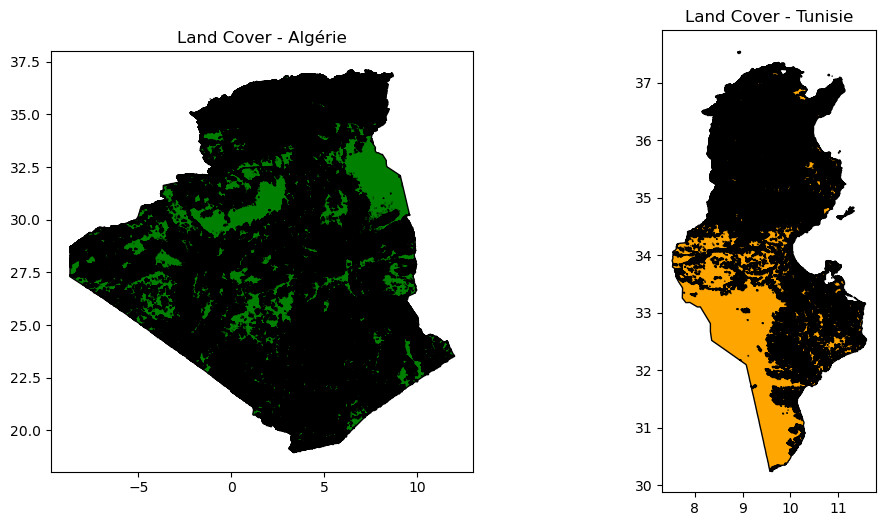

In [4]:
#  Visualiser les Land Cover 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
landcover_alg.plot(ax=ax[0], color='green', edgecolor='black')
ax[0].set_title("Land Cover - Algérie")
landcover_tun.plot(ax=ax[1], color='orange', edgecolor='black')
ax[1].set_title("Land Cover - Tunisie")
plt.show()

# Climat Dataset

In [3]:

#  Fusionner les deux shapefiles 
landcover = gpd.GeoDataFrame(pd.concat([landcover_alg, landcover_tun], ignore_index=True))
landcover = landcover.dissolve()  # fusion géométrique
landcover = landcover.to_crs("EPSG:4326")  # on force la projection en WGS84 (comme WorldClim)



In [4]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = ["precip", "tmin", "tmax"]


#  Boucle sur chaque variable 
for var in variables:
    
    input_dir = os.path.join(base_dir, var)
    output_dir = os.path.join(base_dir, f"{var}_alg_tun")
    os.makedirs(output_dir, exist_ok=True)
    
    # Lister les fichiers .tif (12 mois * 5 années = 60 fichiers)
    tif_files = sorted(glob(os.path.join(input_dir, "*.tif")))
    
    for tif_file in tif_files:
        try:
            # Charger le raster climatique
            ds = rioxarray.open_rasterio(tif_file)
            
            # Reprojeter le shapefile si besoin
            if landcover.crs != ds.rio.crs:
                landcover = landcover.to_crs(ds.rio.crs)
            
            # Découper avec le shapefile fusionné
            ds_crop = ds.rio.clip(landcover.geometry, landcover.crs)
            
            # Sauvegarder le résultat
            output_path = os.path.join(output_dir, os.path.basename(tif_file))
            ds_crop.rio.to_raster(output_path)
            
        except Exception as e:
            print(f" Erreur sur {os.path.basename(tif_file)} : {e}")


# Exploration univariée et bivariée Land Cover Dataset


Résumé statistique des attributs du shapefile :


,geometry,ID,GRIDCODE,AREA,LCCCODE,AREA_M2,LCCCode
count,1,1.0,1.0,1.00,1,1.0,1
unique,1,NaN,NaN,NaN,1,NaN,1
top,MULTIPOLYGON (((-8.197548866271966 27.02694320...,NaN,NaN,NaN,7001 // 8001,NaN,7001 // 8001
freq,1,NaN,NaN,NaN,1,NaN,1
mean,NaN,4.0,210.0,6228187.24,NaN,3110936.0,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,4.0,210.0,6228187.24,NaN,3110936.0,NaN
25%,NaN,4.0,210.0,6228187.24,NaN,3110936.0,NaN
50%,NaN,4.0,210.0,6228187.24,NaN,3110936.0,NaN
75%,NaN,4.0,210.0,6228187.24,NaN,3110936.0,NaN



Nombre de valeurs manquantes par colonne :


geometry    0
ID          0
GRIDCODE    0
AREA        0
LCCCODE     0
AREA_M2     0
LCCCode     0
dtype: int64

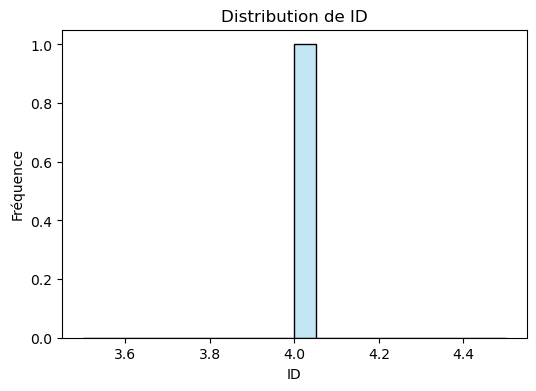

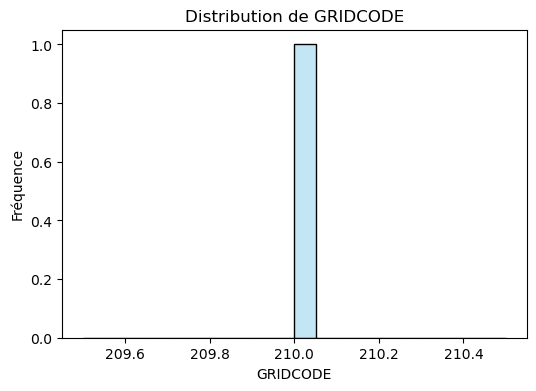

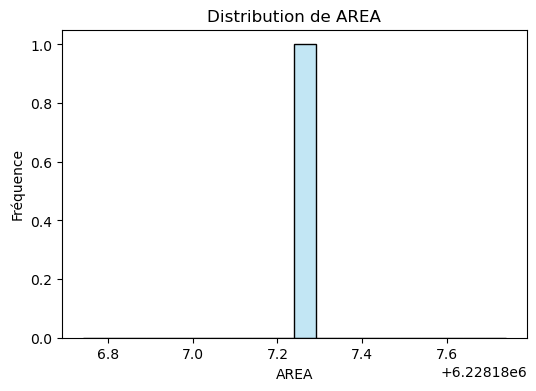

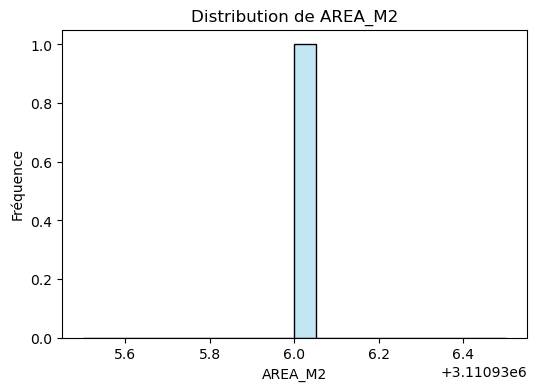

In [7]:
import seaborn as sns
import numpy as np

# --- Pour les shapefiles ---
if 'landcover' in locals():
    print("\nRésumé statistique des attributs du shapefile :")
    display(landcover.describe(include='all'))

    print("\nNombre de valeurs manquantes par colonne :")
    display(landcover.isnull().sum())

    # Histogrammes pour les colonnes numériques
    numeric_cols = landcover.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        plt.figure(figsize=(6,4))
        sns.histplot(landcover[col], kde=True, bins=20, color='skyblue')
        plt.title(f"Distribution de {col}")
        plt.xlabel(col)
        plt.ylabel("Fréquence")
        plt.show()




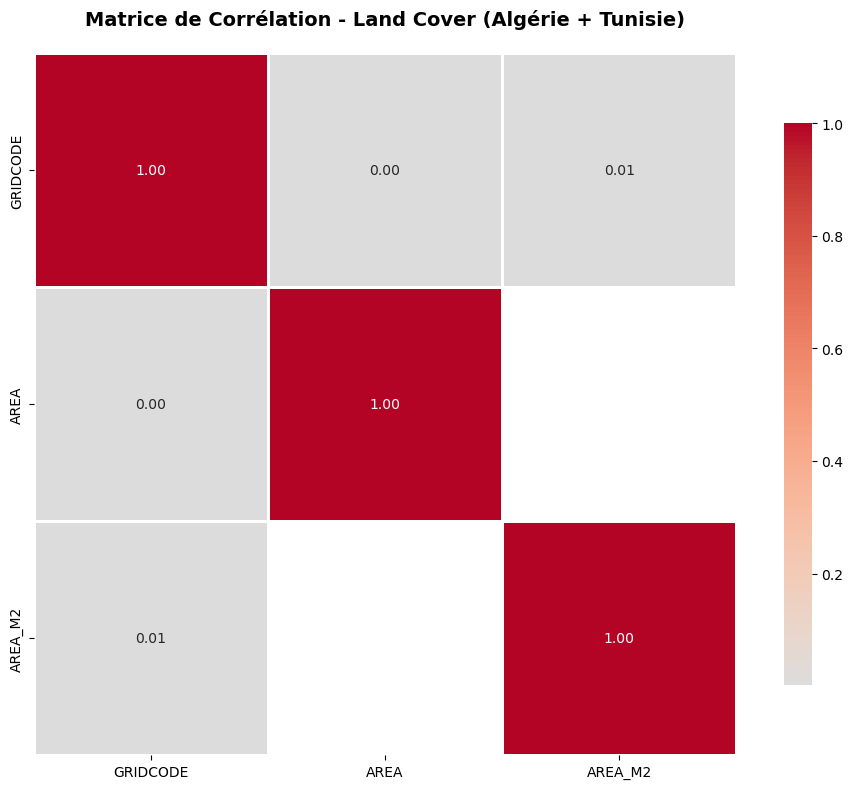

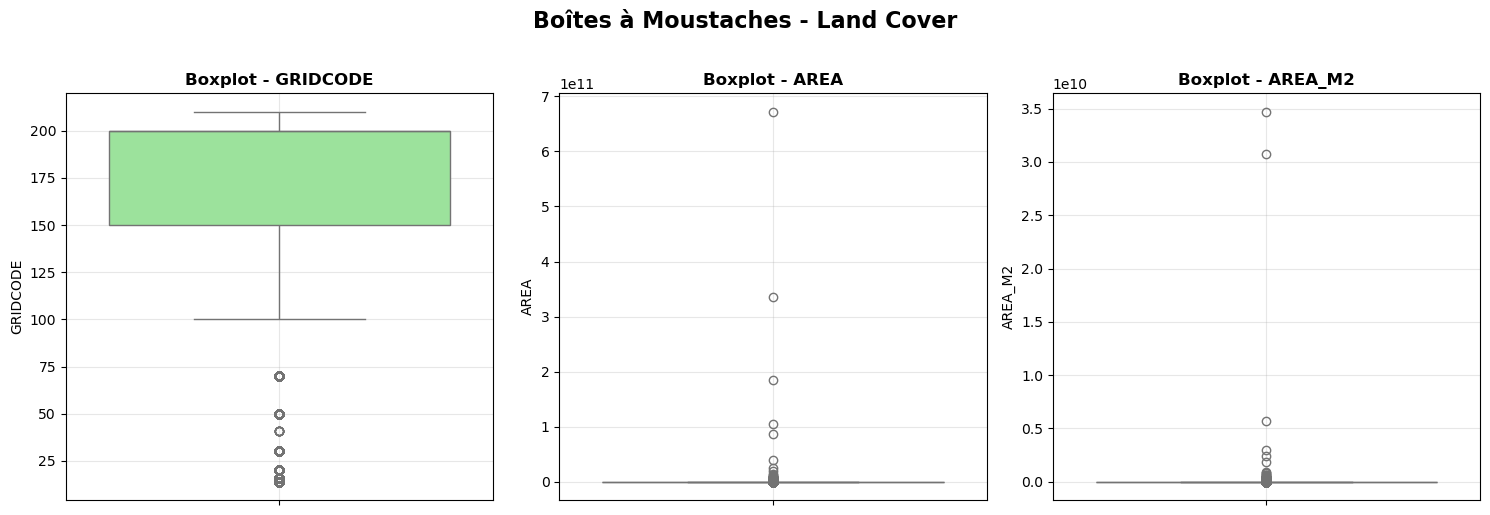

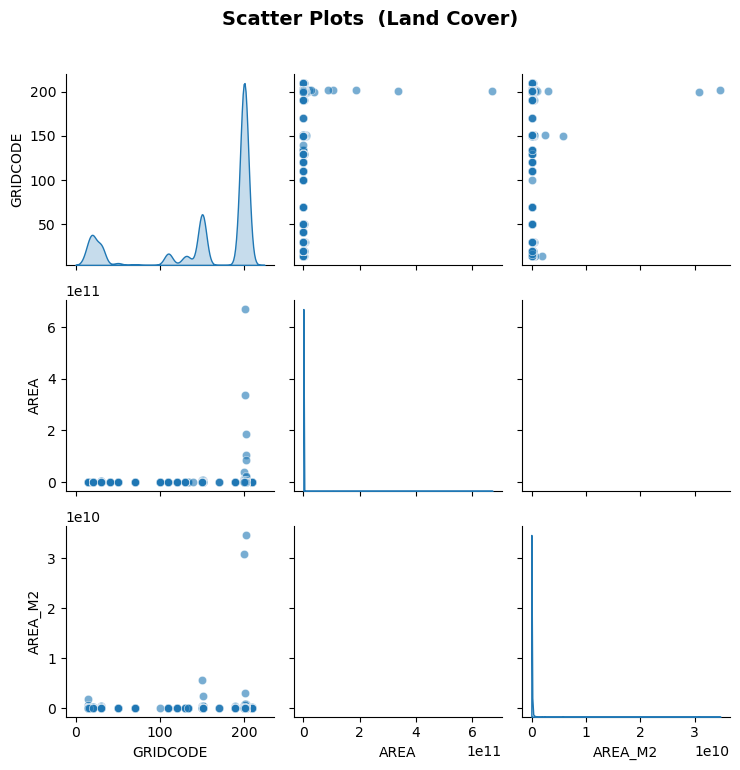

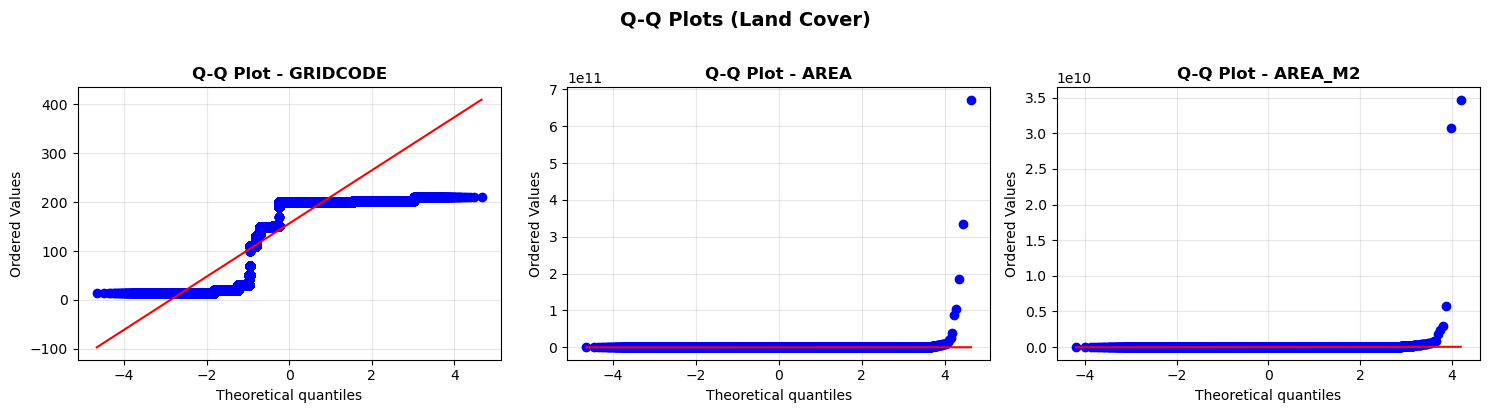

In [18]:
from scipy import stats

if 'landcover_alg' in locals() and 'landcover_tun' in locals():
    
    # Combiner les données numériques des deux pays
    landcover_combined = pd.concat([landcover_alg, landcover_tun], ignore_index=True)
    
    # Sélectionner uniquement les colonnes numériques (sans ID)
    numeric_data = landcover_combined.select_dtypes(include=[np.number])
    if 'ID' in numeric_data.columns:
        numeric_data = numeric_data.drop(columns=['ID'])
    
    if numeric_data.shape[1] > 1:
        # Calculer la matrice de corrélation
        correlation_matrix = numeric_data.corr()
        
        # 1. Matrice de corrélation 
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                    center=0, square=True, linewidths=1, 
                    cbar_kws={"shrink": 0.8}, fmt='.2f')
        plt.title("Matrice de Corrélation - Land Cover (Algérie + Tunisie)", 
                  fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        # 2. Boxplots pour chaque variable numérique
        n_cols = len(numeric_data.columns)
        fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))
        if n_cols == 1:
            axes = [axes]
        
        for idx, col in enumerate(numeric_data.columns):
            sns.boxplot(y=numeric_data[col], ax=axes[idx], color='lightgreen')
            axes[idx].set_title(f"Boxplot - {col}", fontweight='bold')
            axes[idx].set_ylabel(col)
            axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle("Boîtes à Moustaches - Land Cover", fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # 3. Scatter plots 
        if n_cols > 1:
            sns.pairplot(numeric_data, diag_kind='kde', plot_kws={'alpha': 0.6})
            plt.suptitle("Scatter Plots  (Land Cover)", 
                        fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()
        
        # 4. Q-Q Plots 
        n_vars = len(numeric_data.columns)
        fig, axes = plt.subplots(1, n_vars, figsize=(5*n_vars, 4))
        if n_vars == 1:
            axes = [axes]
        
        for idx, col in enumerate(numeric_data.columns):
            stats.probplot(numeric_data[col].dropna(), dist="norm", plot=axes[idx])
            axes[idx].set_title(f"Q-Q Plot - {col}", fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle("Q-Q Plots (Land Cover)", 
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print(" Pas assez de colonnes numériques ")


# Exploration univariée et bivariée Climat Dataset


Précipitations - wc2.1_cruts4.09_5m_prec_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : 0.00 mm
   Valeur max      : 139.12 mm
   Moyenne         : 4.31 mm
   Écart-type      : 10.34 mm
   Nombre de pixels: 32927

Température Min - wc2.1_cruts4.09_5m_tmin_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : -1.50 °C
   Valeur max      : 11.00 °C
   Moyenne         : 5.67 °C
   Écart-type      : 2.11 °C
   Nombre de pixels: 32927

Température Min - wc2.1_cruts4.09_5m_tmin_2024-01.tif
------------------------------------------------------------
   Dimensions      : 248 x 220 pixels
   CRS             : EPSG:4326
   Résolution      : 0.0833°
   Valeur min      : -1.50 °C
   Valeur max      : 11.00 °C
   Moyen

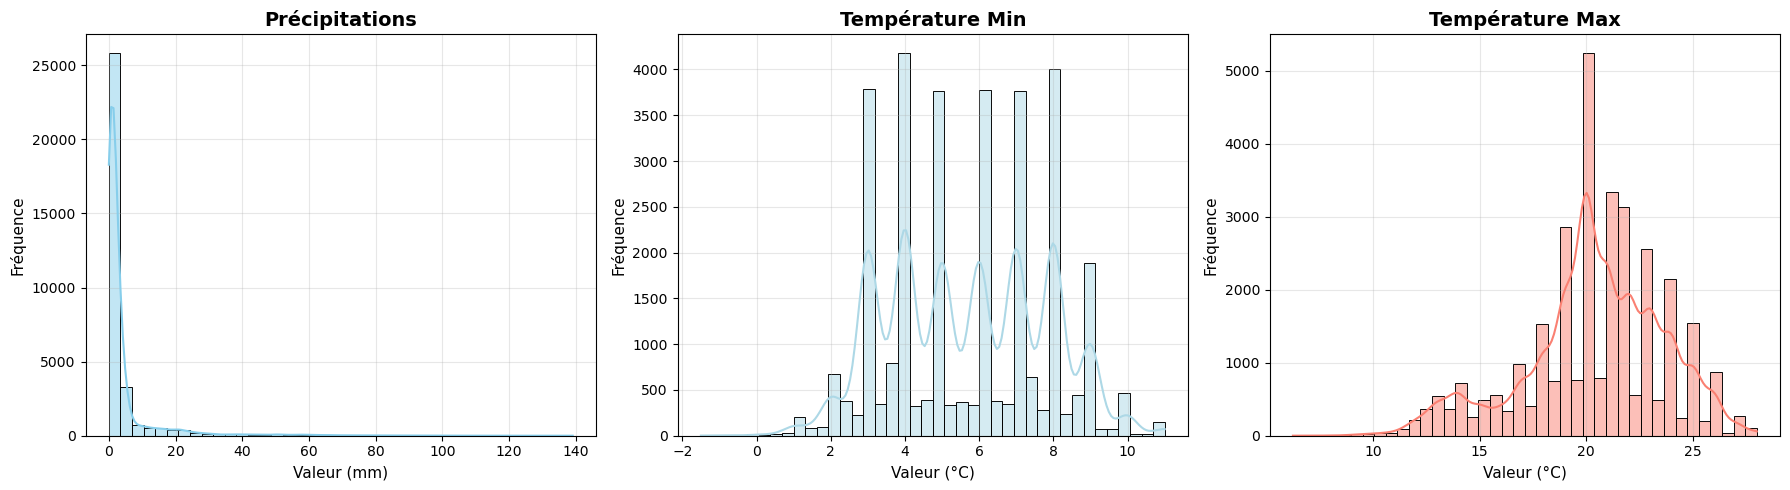

In [19]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = {
    "precip_alg_tun": {"nom": "Précipitations", "unite": "mm", "couleur": "skyblue"},
    "tmin_alg_tun": {"nom": "Température Min", "unite": "°C", "couleur": "lightblue"},
    "tmax_alg_tun": {"nom": "Température Max", "unite": "°C", "couleur": "salmon"}
}


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (var_dir, var_info) in enumerate(variables.items()):
    raster_files = glob(os.path.join(base_dir, var_dir, "*.tif"))
    
    if len(raster_files) > 0:
        # Prendre le premier fichier comme exemple
        raster_path = raster_files[0]
        
        print(f"\n{var_info['nom']} - {os.path.basename(raster_path)}")
        print("-" * 60)
        
        with rasterio.open(raster_path) as raster:
            print(f"   Dimensions      : {raster.width} x {raster.height} pixels")
            print(f"   CRS             : {raster.crs}")
            print(f"   Résolution      : {raster.res[0]:.4f}°")
            
            data = raster.read(1).astype(float)
            
            # Nettoyer les données : supprimer nodata, NaN, et inf
            nodata_value = raster.nodata
            if nodata_value is not None:
                data = data[data != nodata_value]
            
            # Supprimer les NaN et les valeurs infinies
            data = data[~np.isnan(data)]
            data = data[~np.isinf(data)]
            
            # Aplatir le tableau pour l'analyse
            data_flat = data.flatten()
            
            if len(data_flat) > 0:
                print(f"   Valeur min      : {data_flat.min():.2f} {var_info['unite']}")
                print(f"   Valeur max      : {data_flat.max():.2f} {var_info['unite']}")
                print(f"   Moyenne         : {data_flat.mean():.2f} {var_info['unite']}")
                print(f"   Écart-type      : {data_flat.std():.2f} {var_info['unite']}")
                print(f"   Nombre de pixels: {len(data_flat)}")
            else:
                print(f"    Aucune donnée valide trouvée!")
                data_flat = np.array([0])  # Valeur par défaut pour éviter les erreurs
            
            # Histogramme
            if len(data_flat) > 0:
                sns.histplot(data_flat, bins=40, kde=True, 
                            color=var_info['couleur'], ax=axes[idx])
                axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')
                axes[idx].set_xlabel(f"Valeur ({var_info['unite']})", fontsize=11)
                axes[idx].set_ylabel("Fréquence", fontsize=11)
                axes[idx].grid(True, alpha=0.3)
            else:
                axes[idx].text(0.5, 0.5, "Pas de données valides", 
                              ha='center', va='center', fontsize=12)
                axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')
    else:
        print(f"\n Aucun fichier trouvé dans {var_dir}/")
        axes[idx].text(0.5, 0.5, f"Pas de données\n{var_info['nom']}", 
                      ha='center', va='center', fontsize=12)
        axes[idx].set_title(f"{var_info['nom']}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



Dimensions du DataFrame climatique : (10000, 3)
Statistiques descriptives :


,Précipitations,Tmin,Tmax
count,10000.000000,10000.000000,10000.000000
mean,4.264652,5.655258,20.359917
std,10.275296,2.110265,3.304307
min,0.000000,-1.000000,6.250000
25%,0.700000,4.000000,19.000000
50%,1.287500,5.750000,20.250000
75%,3.025000,7.250000,23.000000
max,139.125000,11.000000,28.000000


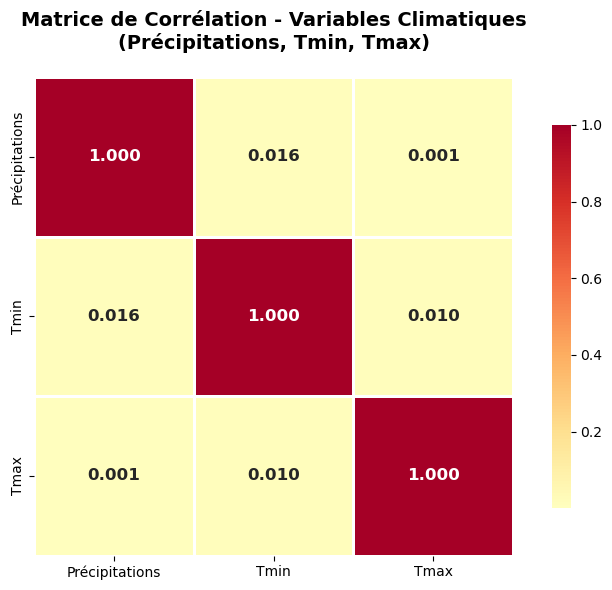

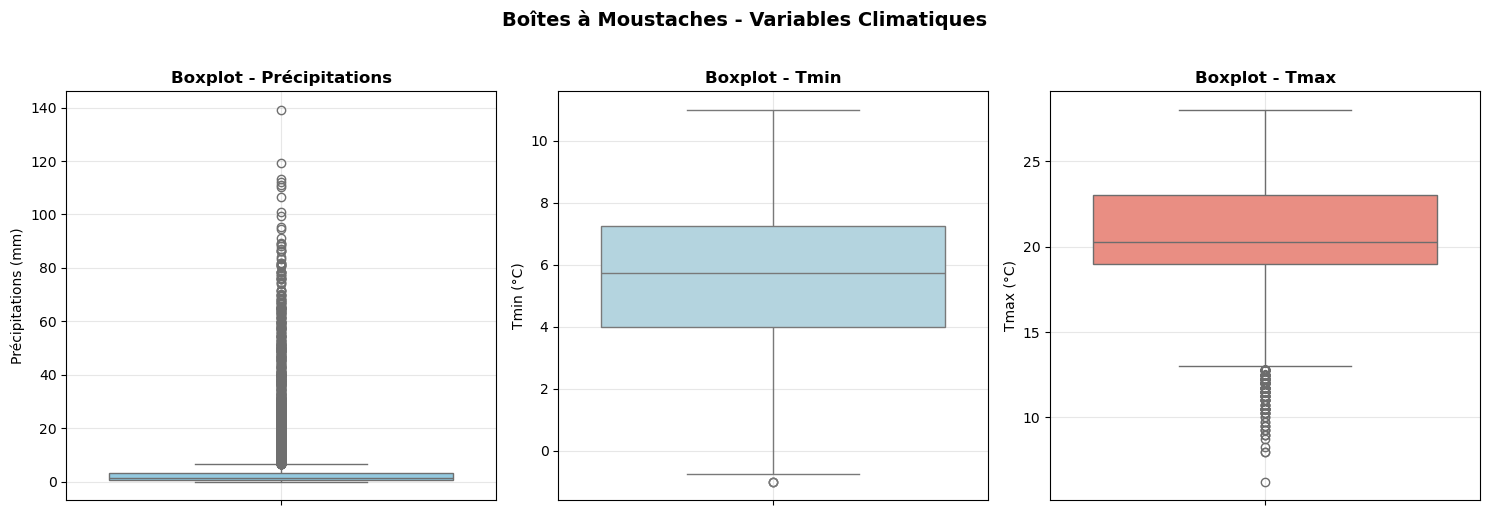

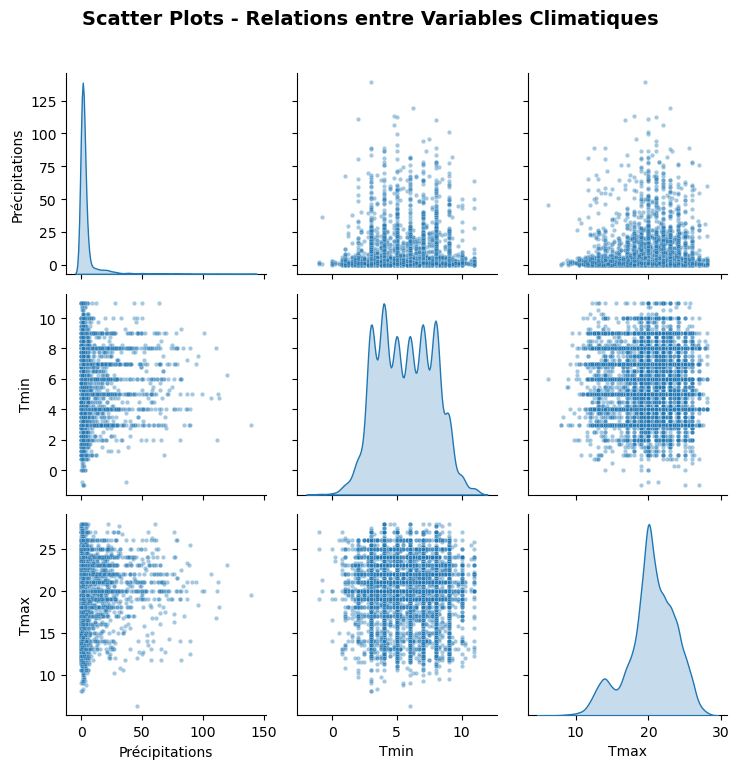

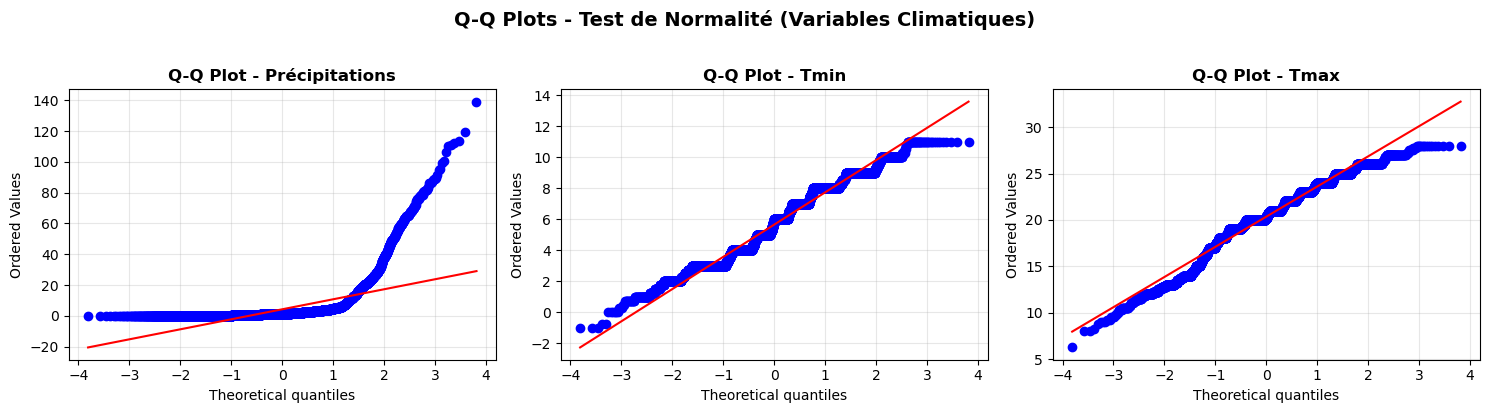

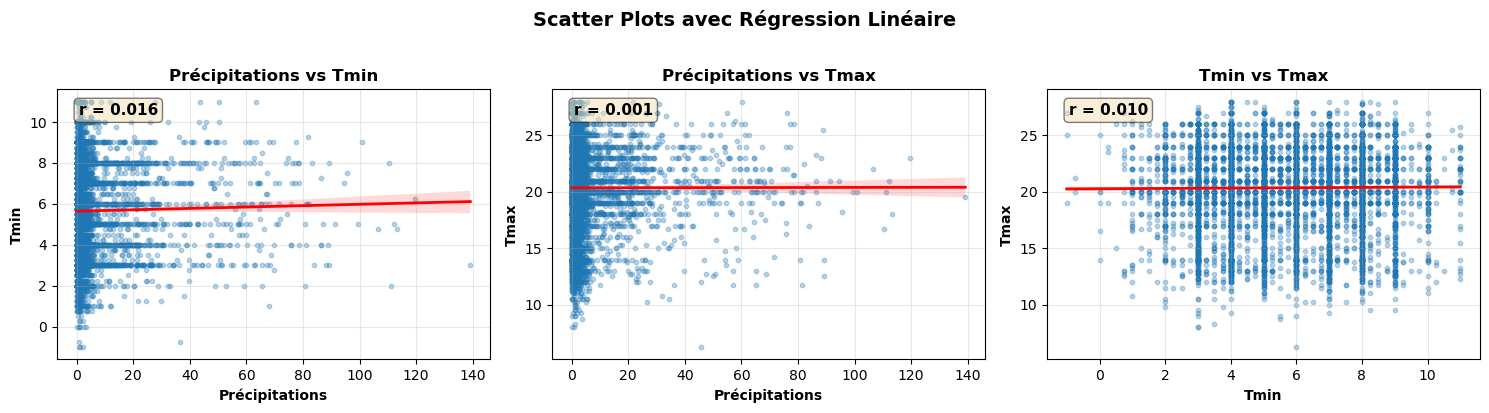

In [21]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = {
    "precip_alg_tun": {"nom": "Précipitations", "unite": "mm"},
    "tmin_alg_tun": {"nom": "Tmin", "unite": "°C"},
    "tmax_alg_tun": {"nom": "Tmax", "unite": "°C"}
}

# Dictionnaire pour stocker les données de chaque variable
climate_data = {}

# Charger un échantillon de données pour chaque variable
for var_dir, var_info in variables.items():
    raster_files = glob(os.path.join(base_dir, var_dir, "*.tif"))
    
    if len(raster_files) > 0:
        # Prendre le premier fichier de chaque variable
        raster_path = raster_files[0]
        
        with rasterio.open(raster_path) as raster:
            data = raster.read(1).astype(float)
            
            # Nettoyer les données
            nodata_value = raster.nodata
            if nodata_value is not None:
                data = np.where(data == nodata_value, np.nan, data)
            
            # Aplatir et nettoyer
            data_flat = data.flatten()
            data_flat = data_flat[~np.isnan(data_flat)]
            data_flat = data_flat[~np.isinf(data_flat)]
            
            # Échantillonner pour éviter trop de données (prendre 10000 points aléatoires)
            if len(data_flat) > 10000:
                sample_indices = np.random.choice(len(data_flat), 10000, replace=False)
                data_flat = data_flat[sample_indices]
            
            climate_data[var_info['nom']] = data_flat

# Créer un DataFrame avec les données climatiques
if climate_data:
    # Trouver la longueur minimale pour aligner les données
    min_length = min([len(v) for v in climate_data.values()])
    
    # Tronquer toutes les séries à la même longueur
    climate_df = pd.DataFrame({
        k: v[:min_length] for k, v in climate_data.items()
    })
    
    print(f"\nDimensions du DataFrame climatique : {climate_df.shape}")
    print(f"Statistiques descriptives :")
    display(climate_df.describe())
    
    # 1. Matrice de corrélation
    correlation_climate = climate_df.corr()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_climate, annot=True, cmap='RdYlBu_r', 
                center=0, square=True, linewidths=2, 
                cbar_kws={"shrink": 0.8}, fmt='.3f', 
                annot_kws={"fontsize": 12, "fontweight": "bold"})
    plt.title("Matrice de Corrélation - Variables Climatiques\n(Précipitations, Tmin, Tmax)", 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # 2. Boxplots pour chaque variable climatique
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    colors = ['skyblue', 'lightblue', 'salmon']
    for idx, (col, color) in enumerate(zip(climate_df.columns, colors)):
        sns.boxplot(y=climate_df[col], ax=axes[idx], color=color)
        axes[idx].set_title(f"Boxplot - {col}", fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(f"{col} ({list(variables.values())[idx]['unite']})", fontsize=10)
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle("Boîtes à Moustaches - Variables Climatiques", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
   
    # 3. Scatter plots 
    sns.pairplot(climate_df, diag_kind='kde', plot_kws={'alpha': 0.4, 's': 10})
    plt.suptitle("Scatter Plots - Relations entre Variables Climatiques", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 4. Q-Q Plots 
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, col in enumerate(climate_df.columns):
        stats.probplot(climate_df[col], dist="norm", plot=axes[idx])
        axes[idx].set_title(f"Q-Q Plot - {col}", fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle("Q-Q Plots - Test de Normalité (Variables Climatiques)", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 5. Scatter plots individuels avec ligne de régression
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    pairs = [
        ('Précipitations', 'Tmin'),
        ('Précipitations', 'Tmax'),
        ('Tmin', 'Tmax')
    ]
    
    for idx, (var1, var2) in enumerate(pairs):
        if var1 in climate_df.columns and var2 in climate_df.columns:
            sns.regplot(x=climate_df[var1], y=climate_df[var2], 
                       ax=axes[idx], scatter_kws={'alpha': 0.3, 's': 10},
                       line_kws={'color': 'red', 'linewidth': 2})
            axes[idx].set_xlabel(var1, fontsize=10, fontweight='bold')
            axes[idx].set_ylabel(var2, fontsize=10, fontweight='bold')
            axes[idx].set_title(f"{var1} vs {var2}", fontsize=12, fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            
            # Ajouter le coefficient de corrélation
            corr = climate_df[var1].corr(climate_df[var2])
            axes[idx].text(0.05, 0.95, f'r = {corr:.3f}', 
                          transform=axes[idx].transAxes,
                          fontsize=11, fontweight='bold',
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle("Scatter Plots avec Régression Linéaire", 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
